In [36]:
# Run some setup code for this notebook.
import pandas as pd

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
def load_data(path):
    df = pd.read_json(path)
    df_expanded = df["user"].apply(lambda x: pd.Series(x))
    df = pd.concat([df.drop("user", axis=1), df_expanded], axis=1)
    return df


df = load_data("./data/train.json")
df2fill = load_data("./data/test.json")

df.head()

,created_at,label,id,id_str,name,screen_name,location,description,url,entities,...,profile_sidebar_fill_color,profile_text_color,profile_use_background_image,has_extended_profile,default_profile,default_profile_image,following,follow_request_sent,notifications,translator_type
0,2019-01-20 03:36:01+00:00,bot,1318284638,1318284638,Syed Haider Naqvi,HNakvi,Islamabad,,None,{'description': {'urls': []}},...,DDEEF6,333333,True,False,True,False,False,False,False,none
1,2019-01-21 21:36:00+00:00,bot,17442457,17442457,Cleveland Clinic MD,CleClinicMD,"Cleveland, Ohio, United States",News and insights for physicians and clinical ...,https://t.co/IxMra2OEey,{'url': {'urls': [{'url': 'https://t.co/IxMra2...,...,D6E9F6,333333,True,False,False,False,False,False,False,none
2,2016-10-11 13:40:17+00:00,bot,102069605,102069605,2NE1 TV,2NE1tv,Seoul,We tweet about 2NE1's video and photo. It’s 2N...,None,{'description': {'urls': []}},...,E3E2DE,634047,True,False,False,False,False,False,False,none
3,2019-01-21 18:42:38+00:00,bot,1367759732,1367759732,Alastair de kretser,Alastairkretser,England,"Travel, tech and stuff 😀",None,{'description': {'urls': []}},...,DDEEF6,333333,True,True,False,False,False,False,False,none
4,2018-11-13 04:09:04+00:00,bot,2927879268,2927879268,Gran Horóscopo,GranHoroscopo,México - Argentina,Tu mejor prediccion diaria ORIGINAL para todos...,https://t.co/rDVUTyCn9E,{'url': {'urls': [{'url': 'https://t.co/rDVUTy...,...,DDEEF6,333333,True,False,True,False,False,False,False,regular


## 数据预处理

In [38]:
def preprocess(d: pd.DataFrame):
    d.drop(["id", "id_str", "utc_offset", "time_zone"], axis=1, inplace=True)

    d.drop(
        [
            "name",
            "screen_name",
            "location",
            "description",
            "url",
            "entities",
            "profile_background_image_url",
            "profile_background_image_url_https",
            "profile_image_url",
            "profile_image_url_https",
            "profile_banner_url",
        ],
        axis=1,
        inplace=True,
    )

    old_columns = list(d.columns[1:])
    d.columns = ["created_at0"] + old_columns
    d.drop(["created_at0"], axis=1, inplace=True)
    d["created_at"] = pd.to_datetime(d["created_at"], infer_datetime_format=True)
    d["created_at"] = d["created_at"].apply(
        lambda x: x.value // (10**9) / (24 * 60 * 60)
    )

    def col2rgb(s: str):
        x = int(s, base=16)
        return pd.Series([x // (256 * 256), (x // 256) % 256, x % 256])

    for name in [
        "profile_background_color",
        "profile_link_color",
        "profile_sidebar_border_color",
        "profile_sidebar_fill_color",
        "profile_text_color",
    ]:
        d_rgb = d[name].apply(col2rgb)
        d_rgb.columns = [name + "_r", name + "_g", name + "_b"]
        d = pd.concat([d.drop([name], axis=1), d_rgb], axis=1)

    d["lang"] = d["lang"].apply(str.lower)

    return d


df_label = pd.get_dummies(df["label"])["human"]
df.drop(["label"], axis=1, inplace=True)
df2fill.drop(["label"], axis=1, inplace=True)


def dummy2(a: pd.DataFrame, b: pd.DataFrame):
    N = len(a)
    concat_dummy = pd.get_dummies(pd.concat([a, b]))
    return concat_dummy[:N], concat_dummy[N:]


df = preprocess(df)
df2fill = preprocess(df2fill)

df, df2fill = dummy2(df, df2fill)

In [39]:
print(df.info())
print(df2fill.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1985
Data columns (total 55 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   protected                       1986 non-null   bool   
 1   followers_count                 1986 non-null   int64  
 2   friends_count                   1986 non-null   int64  
 3   listed_count                    1986 non-null   int64  
 4   created_at                      1986 non-null   float64
 5   favourites_count                1986 non-null   int64  
 6   geo_enabled                     1986 non-null   bool   
 7   verified                        1986 non-null   bool   
 8   statuses_count                  1986 non-null   int64  
 9   contributors_enabled            1986 non-null   bool   
 10  is_translator                   1986 non-null   bool   
 11  is_translation_enabled          1986 non-null   bool   
 12  profile_background_tile         19

In [40]:
df.head()

,protected,followers_count,friends_count,listed_count,created_at,favourites_count,geo_enabled,verified,statuses_count,contributors_enabled,...,lang_ko,lang_nl,lang_pl,lang_pt,lang_ru,lang_th,lang_tr,translator_type_badged,translator_type_none,translator_type_regular
0,False,28533,1164,45,15795.514687,6006,True,False,7446,False,...,0,0,0,0,0,0,0,0,1,0
1,False,299192,1721,1517,14200.615845,401,True,True,25344,False,...,0,0,0,0,0,0,0,0,1,0
2,False,89051,743,307,14614.587801,154,False,False,47479,False,...,1,0,0,0,0,0,0,0,1,0
3,False,43211,237,29,15815.788704,358,False,False,16586,False,...,0,0,0,0,0,0,0,0,1,0
4,False,113300,16422,112,16417.014502,37,True,False,70666,False,...,0,0,0,0,0,0,0,0,0,1


## 数据探索

In [41]:
df_label.value_counts()

1    1130
0     856
Name: human, dtype: int64

In [42]:
continuous_attrs = [
    "created_at",
    "followers_count",
    "friends_count",
    "listed_count",
    "favourites_count",
    "statuses_count",
]

df[continuous_attrs].describe()


,created_at,followers_count,friends_count,listed_count,favourites_count,statuses_count
count,1986.000000,1.986000e+03,1.986000e+03,1986.000000,1986.000000,1.986000e+03
mean,15206.179024,1.150564e+06,2.068517e+04,2935.426485,14604.806647,8.433909e+04
std,819.774583,6.923611e+06,9.538992e+04,18671.513621,40080.914211,1.579607e+05
min,13474.852812,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000e+00
25%,14524.148712,1.221250e+03,3.275000e+02,16.000000,219.000000,1.605700e+04
50%,15115.194144,9.273700e+04,8.670000e+02,174.500000,2611.500000,3.962950e+04
75%,15788.839178,2.336555e+05,2.533500e+03,1260.750000,12878.000000,8.997950e+04
max,17895.801748,1.069380e+08,2.141379e+06,606500.000000,886115.000000,2.766520e+06


In [43]:
import numpy as np

for s in continuous_attrs:
    df[s] = np.log10(1 + df[s])
    df2fill[s] = np.log10(1 + df2fill[s])

for s in ["statuses_count"]:
    df[s] = np.square(df[s])
    df2fill[s] = np.square(df2fill[s])

for s in ["favourites_count"]:
    df[s] = np.power(df[s], 1.35)
    df2fill[s] = np.power(df2fill[s], 1.35)

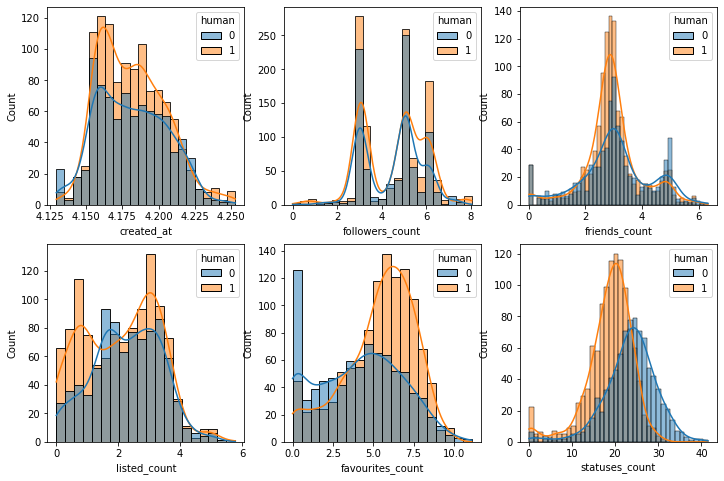

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs_hist = plt.subplots(2, 3, figsize=(12, 8))

for i, s in enumerate(continuous_attrs):
    sns.histplot(data=df, x=s, hue=df_label, kde=True, ax=axs_hist[i // 3, i % 3])

plt.savefig("image/hist.png", dpi=300, bbox_inches = 'tight', facecolor='white')

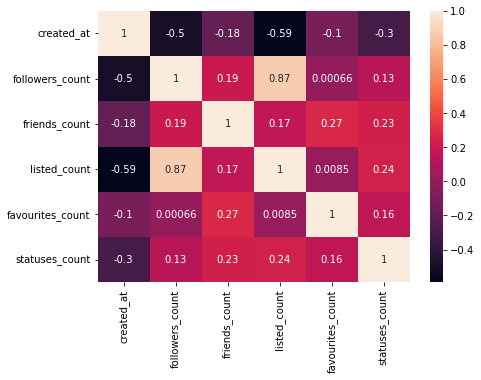

In [45]:
plt.figure(figsize=(7,5))
sns.heatmap(df[continuous_attrs].corr(), annot=True)
plt.savefig("image/heatmap.png", dpi=300, bbox_inches = 'tight', facecolor='white')

## 模型训练

In [46]:
df_label = np.array(df_label)
global X_train, X_test, y_train, y_test
global df2fill_scaled


def make_data():
    from sklearn.model_selection import train_test_split

    global X_train, X_test, y_train, y_test
    global df2fill_scaled

    X_train, X_test, y_train, y_test = train_test_split(df, df_label, test_size=0.2)

    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train.values)
    X_test = scaler.transform(X_test.values)
    df2fill_scaled = scaler.transform(df2fill.values)

make_data()


### 使用 SVM 提取新特征

In [47]:
# def expand_data(k=4, p=0.5):
#     global X_train, X_test, y_train, y_test
#     n_train = X_train.shape[0]
#     n_test = X_test.shape[0]
#     for _ in range(k):
#         from sklearn.svm import LinearSVC

#         idxs = list(np.random.choice(n_train, int(n_train * p), replace=False))
#         SVC_model = LinearSVC(max_iter=5000)
#         SVC_model.fit(X_train[idxs], y_train[idxs])
#         X_train = np.concatenate(
#             (X_train, SVC_model.predict(X_train).reshape((n_train, 1))), axis=1
#         )
#         X_test = np.concatenate(
#             (X_test, SVC_model.predict(X_test).reshape((n_test, 1))), axis=1
#         )


### 逻辑回归

In [48]:
def LR_solve():
    from sklearn.linear_model import LogisticRegression
    LR_model = LogisticRegression(solver="saga", max_iter=1000)
    LR_model.fit(X_train, y_train)
    LR_acc = LR_model.score(X_test, y_test)
    return LR_acc

LR_solve()

0.7638190954773869

### 支持向量机

In [49]:
def LSVC_solve():
    from sklearn.svm import LinearSVC

    LSVC_model = LinearSVC(max_iter=2000)
    LSVC_model.fit(X_train, y_train)
    LSVC_acc = LSVC_model.score(X_test, y_test)
    return LSVC_acc

LSVC_solve()

0.7638190954773869

### 随机森林

In [50]:
def RF_solve():
    from sklearn.ensemble import RandomForestClassifier

    RF_model = RandomForestClassifier(n_estimators=256)
    RF_model.fit(X_train, y_train)
    RF_acc = RF_model.score(X_test, y_test)
    return RF_acc

RF_solve()

0.7713567839195979

### 梯度提升树

In [51]:
def GB_solve():
    from sklearn.ensemble import GradientBoostingClassifier

    GB_model = GradientBoostingClassifier(n_estimators=256)
    GB_model.fit(X_train, y_train)
    GB_acc = GB_model.score(X_test, y_test)
    return GB_acc

GB_solve()

0.7839195979899497

## 模型比较

In [59]:
methods = {
    "Logistic Regression": LR_solve,
    "Linear SVC": LSVC_solve,
    "Random Forest": RF_solve,
    "Gradient Boosting": GB_solve,
}
accs = {name: [] for name in methods.keys()}

for iter in range(5):
    make_data()
    for name, func in methods.items():
        accs[name].append(func())

compare = pd.DataFrame({"Model": [], "Accuracy": []})
for name in methods.keys():
    compare.loc[len(compare)] = [name, np.average(accs[name]) * 100]

compare.sort_values(by="Accuracy", ascending=False)

,Model,Accuracy
2,Random Forest,77.889447
0,Logistic Regression,77.336683
1,Linear SVC,77.336683
3,Gradient Boosting,77.135678
